In [8]:
import os
print(os.getcwd())

c:\Users\Ahmed\Desktop\AdvSecLab\advseceng25-sca-framework-main\src\py


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load(r"..\..\..\data\traces_0.npz")
print(data.files)
print(data['wave'].shape)
num_traces = data['wave'].shape[0]
trace_length = data['wave'].shape[1]

print(f"Number of traces: {num_traces}")
print(f"Trace length: {trace_length} samples")

['wave', 'dut_io_data', 'dut_io_computed_data']
(5000, 150)
Number of traces: 5000
Trace length: 150 samples


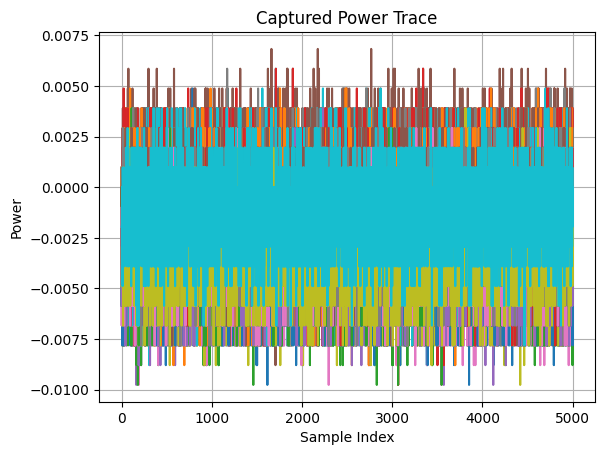

In [3]:
# Example: plot the waveform
waveform = data['wave']
plt.plot(waveform)
plt.title("Captured Power Trace")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.grid(True)
plt.show()

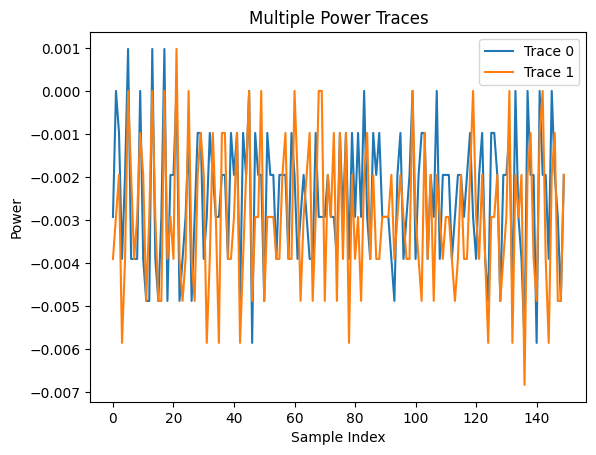

In [18]:
# multiple traces
for i in range(2):  # Plot first 2 traces
    plt.plot(data['wave'][i], label=f"Trace {i}")
plt.legend()
plt.title("Multiple Power Traces")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.show()

In [6]:
data = np.load("C:/Users/Ahmed/Desktop/AdvSecLab/data/traces_0.npz")
print("Keys in .npz:", list(data.keys()))


Keys in .npz: ['wave', 'dut_io_data', 'dut_io_computed_data']


Loaded 5000 traces with length 150.

Saved filtered and normalized traces to 'data/traces_0_processed.npz'


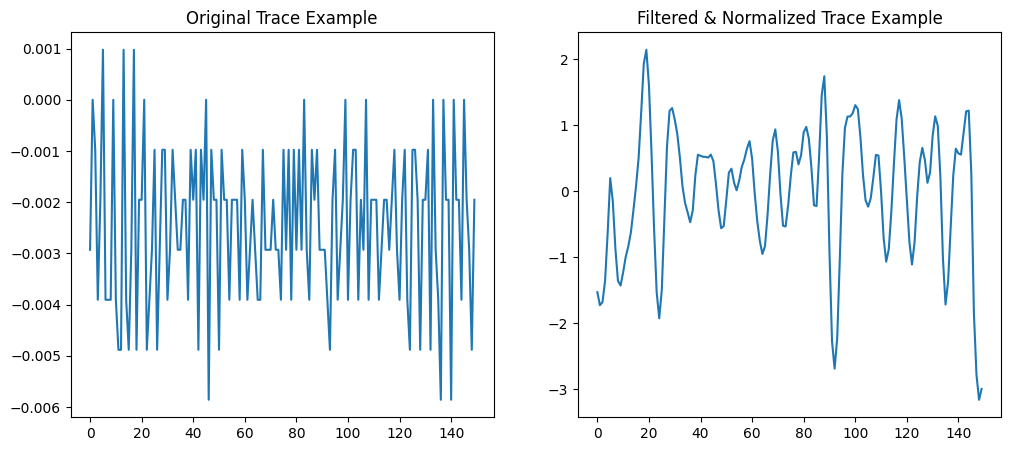

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pywt

def moving_average_filter(traces, window_size=5):
    """Apply moving average smoothing with specified window size."""
    if window_size <= 1:
        return traces  # No filtering
    kernel = np.ones(window_size) / window_size
    return np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=traces
    )

def savgol_filter_traces(traces, window_length=7, polyorder=2):
    """Apply Savitzky-Golay filtering to each trace."""
    if window_length % 2 == 0:
        window_length += 1
    if window_length < polyorder + 2:
        window_length = polyorder + 3 if (polyorder + 3) % 2 == 1 else polyorder + 4
    return np.apply_along_axis(
        lambda m: savgol_filter(m, window_length=window_length, polyorder=polyorder),
        axis=1, arr=traces
    )

def baseline_removal(traces, baseline_window=20):
    """Remove baseline using local moving average."""
    baseline = np.apply_along_axis(
        lambda m: np.convolve(m, np.ones(baseline_window)/baseline_window, mode='same'),
        axis=1, arr=traces
    )
    return traces - baseline

def normalize_traces(traces):
    """Normalize each trace to mean 0 and unit variance."""
    norm_traces = np.copy(traces)
    for i in range(traces.shape[0]):
        trace = traces[i]
        std = np.std(trace)
        if std > 0:
            norm_traces[i] = (trace - np.mean(trace)) / std
        else:
            norm_traces[i] = trace - np.mean(trace)
    return norm_traces

def wavelet_denoise_traces(traces, wavelet='db4', level=3, mode='soft'):
    """Apply wavelet denoising to each trace."""
    denoised_traces = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        coeffs = pywt.wavedec(traces[i], wavelet, level=level)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(traces[i])))

        new_coeffs = [coeffs[0]]  # approximation untouched
        for j in range(1, len(coeffs)):
            new_coeffs.append(pywt.threshold(coeffs[j], threshold, mode=mode))
        denoised = pywt.waverec(new_coeffs, wavelet)
        denoised_traces[i] = denoised[:len(traces[i])]
    return denoised_traces

def preprocess_traces(
    traces,
    do_moving_average=False,
    ma_window_size=5,
    do_savgol=True,
    sg_window_length=5,
    sg_polyorder=2,
    do_baseline_removal=False,
    baseline_window=20,
    do_wavelet=True,
    wavelet='sym2',
    wavelet_level=2,
    wavelet_mode='soft',
    do_normalize=False
):
    """Master preprocessing function applying all filters conditionally."""
    processed = traces.copy()

    if do_moving_average:
        processed = moving_average_filter(processed, ma_window_size)

    if do_savgol:
        processed = savgol_filter_traces(processed, sg_window_length, sg_polyorder)

    if do_baseline_removal:
        processed = baseline_removal(processed, baseline_window)

    if do_wavelet:
        processed = wavelet_denoise_traces(processed, wavelet, wavelet_level, wavelet_mode)

    if do_normalize:
        processed = normalize_traces(processed)

    return processed


def main():
    datafile = os.path.join("..", "..", "..", "data", "traces_0.npz")
    with np.load(datafile, allow_pickle=True) as data:
        waves = data["wave"]
        dut_io_data = data["dut_io_data"]
        dut_io_computed_data = data["dut_io_computed_data"]

    print(f"Loaded {waves.shape[0]} traces with length {waves.shape[1]}.\n")

    # ====== PARAMETERS YOU CAN TUNE =======
    ma_window_size = 5              # moving average window size
    sg_window_length = 7            # savgol filter window length (odd number)
    sg_polyorder = 2                # savgol filter polynomial order
    do_baseline_removal = True      # enable baseline removal
    baseline_window_size = 10       # baseline removal window size

    # Wavelet Denoising Parameters
    do_wavelet_denoising = True
    wavelet_name = 'sym5'
    wavelet_level = 1
    wavelet_mode = 'soft'
    # =====================================

    processed = waves

    if do_wavelet_denoising:
        processed = wavelet_denoise_traces(processed, wavelet=wavelet_name, level=wavelet_level, mode=wavelet_mode)

    processed = moving_average_filter(processed, ma_window_size)
    processed = savgol_filter_traces(processed, sg_window_length, sg_polyorder)

    if do_baseline_removal:
        processed = baseline_removal(processed, baseline_window_size)

    normalized = normalize_traces(processed)

    # Make sure output directory exists
    output_dir = "data"
    os.makedirs(output_dir, exist_ok=True)

    np.savez_compressed(
        os.path.join(output_dir, "traces_0_processed.npz"),
        wave=normalized,
        dut_io_data=dut_io_data,
        dut_io_computed_data=dut_io_computed_data
    )
    print(f"Saved filtered and normalized traces to '{output_dir}/traces_0_processed.npz'")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Trace Example")
    plt.plot(waves[0])
    plt.subplot(1, 2, 2)
    plt.title("Filtered & Normalized Trace Example")
    plt.plot(normalized[0])
    plt.show()

if __name__ == "__main__":
    main()


In [13]:
import matplotlib.pyplot as plt

# Plot first few traces
for i in range(5):
    plt.plot(traces[i], label=f"Trace {i}")
plt.legend()
plt.title("Raw traces before alignment")
plt.xlabel("Time sample")
plt.ylabel("Power")
plt.show()


NameError: name 'traces' is not defined